### Усложняем динамику для Gravity_lens

Теперь:
r''_FCS = u_FCS - a_FCS - S^T * (S'' * r_FCS + 2 * S' * r'_FCS)

In [71]:
import sys
sys.path.append("C:/Users/snr/kiam_rl")

import numpy as np
from datetime import datetime
import stable_baselines3
from rl_routines import RLProblem, Environment
from rl_routines import ActorCriticNetworks, get_CustomActorCriticPolicy
from rl_routines import evaluate_policy, statistics
import gymnasium as gym
import numpy 
from numpy.linalg import norm
from stable_baselines3 import PPO
import torch
import math
import random
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.tensorboard import SummaryWriter
from scipy.integrate import solve_ivp
from datetime import datetime, timedelta

from scipy.spatial.transform import Rotation as R, Slerp

In [72]:
from Dynamics_SGLF import Dynamics_SGLF

In [ ]:
""" параметры задачи """
t0_data = datetime(2030, 9, 1, 0, 0) # начало отсчета, дата
t0 = 0.
# Орбитальные параметры экзопланеты:
Orb_param_exo_array = np.array([
    1. ,  # большая полуось (а.е)
    1. ,  # период обращения (годы)
    0.0167086,  # эксцентриситет
    -240., 352.5, 37.5,  # аргументы орбиты (град)
    datetime(2021, 1, 2)  # начальное время (дата)
])

# Массы тел (в кг):
M_sun = 1.989 * 1e30  # масса Солнца (кг)
M_JSUN_array = np.array([
    1.8982e27,  # Юпитер (кг)
    5.6834e26,  # Сатурн
    8.6810e25,  # Уран
    1.02413e26  # Нептун
])

# Орбитальные параметры планет-гигантов:
Orb_param_JSUN_array = np.array([
    [5.2044 , 11.862 , 0.0489, 100.464, 273.867, 1.303, datetime(2023, 1, 21)],  #[a, T, e, Omega, w, i, t0]
    [9.5826 , 29.4571 , 0.0565, 113.665, 339.392, 2.485, datetime(2032, 11, 29)],
    [19.2184 , 84.0205 , 0.046381, 74.006, 96.998857, 0.773, datetime(2050, 8, 19)],
    [30.07, 164.8 , 0.008678, 131.784, 276.336, 1.767957, datetime(2042, 9, 4)]])

# Константы новых единиц измерения:
KM_SCALE = 100_000.  # 1 единица = 100 000 км
SEC_SCALE = 100_000.  # 1 единица = 100 000 сек
VEL_SCALE = KM_SCALE / SEC_SCALE # 1 единица = 1 км/сек

R0 = 100_000. / KM_SCALE  # Начальный радиус области инициализации аппарата (100 000 км) 
z = 550 * 1.496e+8 / KM_SCALE  # Расстояние от Солнца до КА (550 ае) 
z0 = 10.0 * 9.461e12 / KM_SCALE  # Расстояние от экзопланеты до Солнца (10 св лет)
DT = 0.05  # # Шаг для t_span (solve_ivp) 0.05
n_imp = 6  # Количество импульсов

delta_v_max = 01. / VEL_SCALE  # Максимальный импульс (км/сек) 0.1
tfinal = 30.0 * 24. * 3600. / 100_000.  # Время эпизода 30 дней в SEC_SCALE
T_YEARS = 30. / 365.25 # Время эпизода 30 дней в ГОДАХ
alfa = 1.0  # Коэффициент в функции награды награды для единиц _SCALE
V_0 = 0.2  # Начальная скорость (км/сек)
h_interp = 0.001 * 365.25 * 24. * 3600. / SEC_SCALE  # Интервал времени в секундах, преобразованный с учетом SEC_SCALE

time_grid = np.arange(t0, tfinal +  h_interp, h_interp)

#total_timesteps = len(time_grid)  # Количество шагов в time_grid
total_timesteps = 5_000

In [74]:
# Предвычисление
tmp_dyn = Dynamics_SGLF(
    Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array,
    t0, t0_data, z0, T_YEARS, h_interp, time_grid)

# Убедитесь, что метод precompute был вызван, перед тем как обращаться к атрибутам
tmp_dyn.precompute()

# Теперь можно получить предвычисленные данные
precomputed_data = tmp_dyn.quat_array, tmp_dyn.omega_array, tmp_dyn.epsilon_array


# # === ОДИН РАЗ: Предвычисление динамики ===
# dyn_for_precompute = Dynamics_SGLF(
#     Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array,
#     t0, t0_data, z0, T_YEARS, h_interp, time_grid)

dyn = Dynamics_SGLF(Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array,t0, t0_data, z0, T_YEARS, h_interp, time_grid)
dyn.precompute()

# здесь quat_array, omega_array, epsilon_array уже готовы
quat_array = dyn.quat_array
omega_array = dyn.omega_array
epsilon_array = dyn.epsilon_array


precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precomputing...
precompu

In [75]:
def random_date(start, end):
    """Генерация рандомной даты"""
    delta = end - start
    random_days = random.randint(0, delta.days)
    return start + timedelta(days=random_days)

In [76]:
KM_IN_AU = 149_597_870.7  # 1 а.е. в километрах
SEC_IN_YEAR = 365.25 * 24 * 3600  # Секунд в году
SCALE_DIST = KM_IN_AU / 100_000.0  # 1 твоя единица = 100 000 км = (100_000 / 149_597 870) а.е.
SCALE_VEL = (SEC_IN_YEAR) / SCALE_DIST  # Конвертирование скоростей км/с в а.е./год

class Dynamics_Problem(RLProblem):
    # В начало класса Dynamics_Problem (перед __init__)
    KM_IN_AU = 149_597_870.7  
    SEC_IN_YEAR = 365.25 * 24 * 3600  
    SCALE_DIST = KM_IN_AU / 100_000.0  
    SCALE_VEL = (SEC_IN_YEAR) / SCALE_DIST  
    def __init__(self, R0, tfinal, T_YEARS, n_imp, delta_v_max, alfa, t0, t0_data, z, z0, precomputed):
        super().__init__()
        self.R0 = R0 # 100_000 км
        self.tfinal = tfinal # 100_000 сек
        self.n_imp = n_imp
        self.time_step = self.tfinal / self.n_imp #интервал между импульсами, 100_000 сек
        self.delta_v_max = delta_v_max # км/сек
        self.alfa = alfa # в единицах _SCALE
        self.t0 = t0 # начало отсчета, 100_000сек
        self.t0_data = t0_data # начальная дата , дата
        self.z0 = z0 # 100_000км
        self.z = z # 100_000км
        self.nostep = 0 # начальный шаг
        self.T_YEARS = T_YEARS
        # Случайная начальная дата в заданном диапазоне
        start_date = self.t0_data
        end_date = datetime(2100, 12, 31)
        self.t0_data_agent = random_date(start_date, end_date) # начальная дата для агента
        # Преобразуем дату агента в годы относительно t0_data
        delta = self.t0_data_agent - self.t0_data
        self.t0_agent_years = delta.total_seconds() / (3600. * 24. * 365.25)

        self.dynamics =  Dynamics_SGLF(Orb_param_exo_array, M_sun, M_JSUN_array, Orb_param_JSUN_array,
            t0, self.t0_data_agent, z0, T_YEARS, h_interp, time_grid,
            precomputed=precomputed)
        
    @property
    def observation_space(self):  
        """
        Размерность вектора наблюдений:
        - Фазовый вектор (6,)
        - Кватернион q -> 4
        - Угловая скорость omega -> 3
        - Угловое ускорение epsilon -> 3
        - Ускорение Солнца d^2r_sun/dt^2 (3,)
        Общая размерность: 6 + 4 + 3 + 3 + 3 = 19
        """
        return gym.spaces.Box(
            low=-numpy.inf, high=numpy.inf, shape=(6,), dtype=numpy.float64)
        
    @property
    def action_space(self):  
        """
        Размерность вектора действия совпадает с размерностью скорости агента (3)
        
        """
        return gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=numpy.float32)
    
    def initialize(self):
        """
        Инициализация начального положения и времени.
        Генерация начального состояния аппарата в соответствии с условиями:
        z0 = 550 a.e.
        r0 = [x0, y0, z0], v0 = [0, 0, V0], где x0^2 + y0^2 ≤ R0^2.
        
        Returns
        -------
        t0 : float
            Начальный момент времени (обычно 0).
        x0 : np.ndarray, shape (6,)
            Начальный фазовый вектор (положение и скорость).
            Начальное положение выбирается из области: y0^2 + z0^2 ≤ R0^2.
        """
        #t0_data_agent = self.t0_data_agent
        self.t0_data_agent = random_date(self.t0_data, datetime(2100, 12, 31))
        delta = self.t0_data_agent - self.t0_data
        self.t0_agent_years = delta.total_seconds() / (3600. * 24. * 365.25)
        
        S = self.dynamics.basis_FCS(t=self.t0_agent_years)[0]
        dS_dt, _ = self.dynamics.dS_dt(t=self.t0_agent_years)
        dRdt_SSB_0, _ = self.dynamics.r_sun_deriv(t=self.t0_agent_years)

        self.nostep = 0
        while True:
            x0 = np.random.uniform(-self.R0, self.R0)
            y0 = np.random.uniform(-self.R0, self.R0)
            if x0**2 + y0**2 <= self.R0**2:
                break

        p0_FCS = np.array([x0, y0, self.z0])
        drdt_SSB_0 = V_0 * S[:, 2]
        dpdt_FCS_0 = S.T @ (drdt_SSB_0 - dRdt_SSB_0 - dS_dt @ p0_FCS)
        # Переводим начальные условия в единицы динамики
        p0_FCS_AU = p0_FCS #/ SCALE_DIST
        dpdt_FCS_AU_per_year = dpdt_FCS_0 #/ SCALE_VEL

        #X0 = np.concatenate((p0_FCS, dpdt_FCS_0))
        X0 = np.concatenate((p0_FCS_AU, dpdt_FCS_AU_per_year))
        self.X_old = X0.copy()
        #print("initialize",X0)
        return self.t0_agent_years, X0
    
    def action2u(self, action):
        """
        Функция, переводящая выход стратегии (нейросети) в импульс.
        Проверяет, что импульс удовлетворяет ограничениям.
        Возвращает импульс (в виде массива [dVx, dVy, dVz]).

        dV: float
            лежит в [-0.1; 0.1]
        """
        delta_v = action * min(1, self.delta_v_max / numpy.linalg.norm(action))
        return delta_v
    
    def time_sec_to_years(self, t):
        if isinstance(t, datetime):
            delta = t - self.t0_data
            t_sec = delta.total_seconds()
        else:
            t_sec = t
        return t_sec / SEC_SCALE

    def Dynamics(self, t):
        """
        Возвращает q, omega,eepsilon и вторую производную по времени от r_sun.
        """
        _, d2r_sun_dt = self.dynamics.r_sun_deriv(t)
        q, omega, epsilon = self.dynamics.get_dynamics(t)
        return q, omega, epsilon, d2r_sun_dt

    def equations_of_motion(self, t, X):
        """
        Возвращает правую часть уравнений движения dx/dt = f(t, x, u)
        Для текущей задачи размерность x равна 6
        x' = (v, f)

        Parameters
        ----------
        t : float
            Текущий момент времени
        x : np.ndarray, shape(6,)
            Текущий фазовый вектор x = (r, v)
        
        Returns
        -------
        dx/dt(t, x) : np.ndarray, shape(6,)
            Правая часть уравнений.
            Импульсы тут НЕ учитываются
        """
            # Перевести X обратно в нормальные единицы для динамики
        pos_km = X[:3] * SCALE_DIST
        vel_kmps = X[3:] * SCALE_VEL
        # Собрать обратно полный вектор
        X_real = np.concatenate((pos_km, vel_kmps))

        q, omega_g, epsilon_g, d2R_SSB = self.Dynamics(t)
        q_rot = R.from_quat(q)
        q_inv = q_rot.inv()
        d2R_FCS = q_inv.apply(d2R_SSB)

        #p_FCS = X[:3]
        #dpdt_FCS = X[3:]
        
        p_FCS = X_real[:3]
        dpdt_FCS = X_real[3:]
        d2pdt2_FCS = - d2R_FCS - 2 * np.cross(omega_g, dpdt_FCS) \
                     - np.cross(epsilon_g, p_FCS) - np.cross(omega_g, np.cross(omega_g, p_FCS))
        # Вернуть обратно в масштабе агента (а.е. и а.е./год)
        dpdt_scaled = dpdt_FCS / SCALE_DIST
        d2pdt2_scaled = d2pdt2_FCS / SCALE_VEL

        #return np.concatenate((dpdt_FCS, d2pdt2_FCS), axis=0) #строка 
        return np.concatenate((dpdt_scaled, d2pdt2_scaled), axis=0)
    
    # def step(self, t, X, delta_v):
    #     """
    #     Шаг моделирования: агент применяет импульс, и состояние обновляется.
    #     """
    #     self.X_old = X.copy()
    #     self.nostep += 1
    #     X_new = X.copy().astype(np.float64)
    #     X_new[3:] += delta_v
    #     t_next = t + self.time_step
    #     if t_next > self.dynamics.time_grid[-1]:
    #         # Обработка выхода за границу времени
    #         t_next = self.dynamics.time_grid[-1]
    #         truncated = True
    #     else:
    #         truncated = self.nostep >= self.n_imp
    #     #sol = solve_ivp(self.equations_of_motion, (t, t_next), X_new, method='RK23', t_eval=[t_next])
    #     sol = solve_ivp(self.equations_of_motion, (t, t_next), X_new, method='RK45', t_eval=np.linspace(t, t_next, 5))    
    #     #sol = solve_ivp(self.equations_of_motion, (t, t + self.time_step), X_new, method='RK23', t_eval=[t + self.time_step])
    #     X_new = sol.y[:, -1].copy()

    #     terminated = False
    #     truncated = self.nostep >= self.n_imp
    #     return t + self.time_step, X_new, terminated, truncated

    def step(self, t, X, delta_v):
        self.X_old = X.copy()
        self.nostep += 1
        X_new = X.copy().astype(np.float64)

        # Преобразовать delta_v в единицы динамики
        delta_v_real = delta_v #/ SCALE_VEL
        X_new[3:] += delta_v_real

        t_next = t + self.time_step
        if t_next > self.dynamics.time_grid[-1]:
            t_next = self.dynamics.time_grid[-1]
            truncated = True
        else:
            truncated = self.nostep >= self.n_imp

        sol = solve_ivp(self.equations_of_motion, (t, t_next), X_new, method='RK45', t_eval=np.linspace(t, t_next, 5), rtol=1e-3, atol=1e-5)
    
        X_new = sol.y[:, -1].copy()
        #print(X_new)

        terminated = False
        truncated = self.nostep >= self.n_imp
        return t + self.time_step, X_new, terminated, truncated

    def rho(self, X):
        """Вычисляет значение ρ(x) по формуле: sqrt(y^2 + z^2) + α * sqrt( (v_y^2 + v_z^2))"""
        x = X[0]
        y = X[1]  # Компоненты позиции
        vx = X[3]
        vy = X[4]  # Компоненты скорости
        #print( "xy ", numpy.sqrt((x)**2 + (y)**2)/100_000.)
        #print("vx vy ", self.alfa * numpy.sqrt(vy**2 + vx**2) /1_000.)
        return numpy.sqrt((x)**2 + (y)**2)/100_000. + self.alfa * numpy.sqrt(vx**2 + vy**2) /1_000.

    def reward(self, t, X_new, delta_v,  terminated, truncated):
        reward = 0
        # Вычисляем ρ(x_k) и ρ(x_(k+1))
        rho_old = self.rho(self.X_old)
        rho_new = self.rho(X_new)
        # Вознаграждение за улучшение расстояния (уменьшение ρ)
        r_k = rho_old - rho_new
        #r_k = rho_old - rho_new
        reward += r_k
        #print("reward:", reward)
        return reward
    
    # def perception_model(self, t, X):
    #     """
    #     Возвращает полный вектор наблюдений:
    #     - Фазовый вектор (6,)
    #     - Кватернион q -> 4
    #     - Угловая скорость omega -> 3
    #     - Угловое ускорение epsilon -> 3
    #     - Ускорение Солнца d^2r_sun/dt^2 (3,)
    #     """
    #     #q, omega, epsilon, d2r_sun_dt = self.Dynamics(t)
    #     #observation = np.concatenate((X, q, omega, epsilon, d2r_sun_dt))
    #     # использовать для наблюдений только компоненты x,y,vx,vy?????
    #     # index = [2,5]
    #     # new_X = np.delete(X, index)
    #     print(X)
    #     return X
    def perception_model(self, t, X):
        """
        Преобразует фазовый вектор X в удобные агентские единицы:
        - Позиции в единицах 100_000 км
        - Скорости в единицах 100_000 км за 100_000 сек
        """
        pos = X[:3] * self.SCALE_DIST / 100_000.0  # Позиции: масштабирование 
        vel = X[3:] * self.SCALE_VEL   # Скорости: сначала в км/с, потом на 100_000 сек, потом в 100_000 км  * 100_000.0 / 100_000.0
        observation = np.concatenate((pos, vel))
        observation = (observation - np.mean(observation)) / np.std(observation)
        #print("Perception observation:", observation)
        return observation

    
# Создание Dynamics_Problem с передачей предвычисленного
problem_with_dynamics = Dynamics_Problem(R0 = R0, tfinal = tfinal, T_YEARS = T_YEARS, n_imp = n_imp, delta_v_max = delta_v_max, alfa = alfa, t0=t0, t0_data=t0_data , z=z, z0=z0, precomputed=precomputed_data)

env_with_dynamics = DummyVecEnv([lambda: Monitor(Environment(problem_with_dynamics))])


In [77]:
import torch.nn as nn

class Dynamics_ActorCriticNetworks(ActorCriticNetworks):
    def __init__(self, feature_dim=6):
        """
        feature_dim: размерность входных данных (наблюдений), теперь 6
        last_layer_dim_pi: размерность последнего слоя политики (π)
        last_layer_dim_vf: размерность последнего слоя ценности (V)
        """
        last_layer_dim_pi = 6
        last_layer_dim_vf = 6
        super().__init__(feature_dim, last_layer_dim_pi=last_layer_dim_pi, last_layer_dim_vf=last_layer_dim_vf)

        # Policy network (π)
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi),  # Aπ1 * o + bπ1
            nn.Tanh(),
        )

        # Value network (V)
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf),  # Av1 * o + bv1
            nn.Tanh(),
        )

Gravity1_ActorCriticNetworks = get_CustomActorCriticPolicy(Dynamics_ActorCriticNetworks)


In [78]:
# import torch.nn as nn

# class Dynamics_ActorCriticNetworks(ActorCriticNetworks):
#     def __init__(self, feature_dim=36):
#         """
#         feature_dim: размерность входных данных (наблюдений), теперь 19
#         last_layer_dim_pi: размерность последнего слоя политики (π)
#         last_layer_dim_vf: размерность последнего слоя ценности (V)
#         """
#         last_layer_dim_pi = 6
#         last_layer_dim_vf = 6
#         hidden_dim = 64  # Размерность дополнительного скрытого слоя
#         super().__init__(feature_dim, last_layer_dim_pi=last_layer_dim_pi, last_layer_dim_vf=last_layer_dim_vf)

#         # Policy network (π)
#         self.policy_net = nn.Sequential(
#             nn.Linear(feature_dim, hidden_dim),  # Вход -> скрытый слой
#             nn.Tanh(),
#             nn.Linear(hidden_dim, last_layer_dim_pi),  # Скрытый слой -> последний слой политики
#             nn.Tanh(),
#         )

#         # Value network (V)
#         self.value_net = nn.Sequential(
#             nn.Linear(feature_dim, hidden_dim),  # Вход -> скрытый слой
#             nn.Tanh(),
#             nn.Linear(hidden_dim, last_layer_dim_vf),  # Скрытый слой -> последний слой ценности
#             nn.Tanh(),
#         )

# Gravity_ActorCriticNetworks = get_CustomActorCriticPolicy(Dynamics_ActorCriticNetworks)


In [ ]:
device = 'cpu'  

init_choice = input("Выберите тип инициализации весов ('z' - нули, 'r' - случайные, 'f' - из файла): ").strip().lower()

# Функция для инициализации весов нулями
def initialize_weights_zeros(model):
    for m in model.policy.children():
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight, 0.0)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
    print("Веса инициализированы нулями.")

# Функция для инициализации случайными весами
def initialize_weights_random(model):
    for m in model.policy.parameters():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.uniform_(m.weight, -0.1, 0.1)  # Инициализация весов
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)  # Инициализация смещений

# Создание модели
model = PPO(                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    Gravity1_ActorCriticNetworks,
    env_with_dynamics,
    n_steps=10000,  
    batch_size=10000, 
    n_epochs=30, 
    learning_rate=0.001,
    verbose=2,
    device=device,
    tensorboard_log='Dynamics_SGLF',
    policy_kwargs={'log_std_init': -5.},
    gamma=1.0)

# было policy_kwargs={'log_std_init': -5.}, ent_coef=0.1
if init_choice == 'z':
    initialize_weights_zeros(model)
elif init_choice == 'r':
    initialize_weights_random(model)
elif init_choice == 'f':
    weights_file = input("Введите путь к файлу весов: ").strip()
    if os.path.exists(weights_file):
        model = PPO.load(weights_file, env=env_with_dynamics)
        print(f"Веса загружены из {weights_file}.")
    else:
        print(f"Файл {weights_file} не найден. Используются стандартные начальные веса.")
else:
    print("Используются стандартные начальные веса.")


Using cpu device


In [80]:
# Обучение модели
model.learn(total_timesteps=total_timesteps)

Logging to Dynamics_SGLF\PPO_100


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12       |
|    ep_rew_mean     | -22.8    |
| time/              |          |
|    fps             | 65       |
|    iterations      | 1        |
|    time_elapsed    | 151      |
|    total_timesteps | 10000    |
---------------------------------


In [81]:

def my_statistics(X):
    q0 = numpy.quantile(X, 0.00)
    q1 = numpy.quantile(X, 0.10)
    q2 = numpy.quantile(X, 0.20)
    q3 = numpy.quantile(X, 0.30)
    q4 = numpy.quantile(X, 0.40)
    q5 = numpy.quantile(X, 0.50)
    q6 = numpy.quantile(X, 0.60)
    q7 = numpy.quantile(X, 0.70)
    q8 = numpy.quantile(X, 0.80)
    q9 = numpy.quantile(X, 0.90)
    q10 = numpy.quantile(X, 1.00)
    # mean = numpy.mean(x)
    # std = numpy.std(x)
    # cv = mean / std
    return q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 # , mean, std, cv

from stable_baselines3.common.evaluation import evaluate_policy
episode_rewards, episode_lengths = evaluate_policy(
    model, model.get_env(), n_eval_episodes=10, return_episode_rewards=True, render=False)

print(my_statistics(episode_rewards))


(-32.579476, -28.1849389, -26.2753586, -24.0502332, -16.8353514, -10.4814135, -8.051333600000001, -5.442197000000002, -0.47249479999999994, -0.0198244, -0.01873)


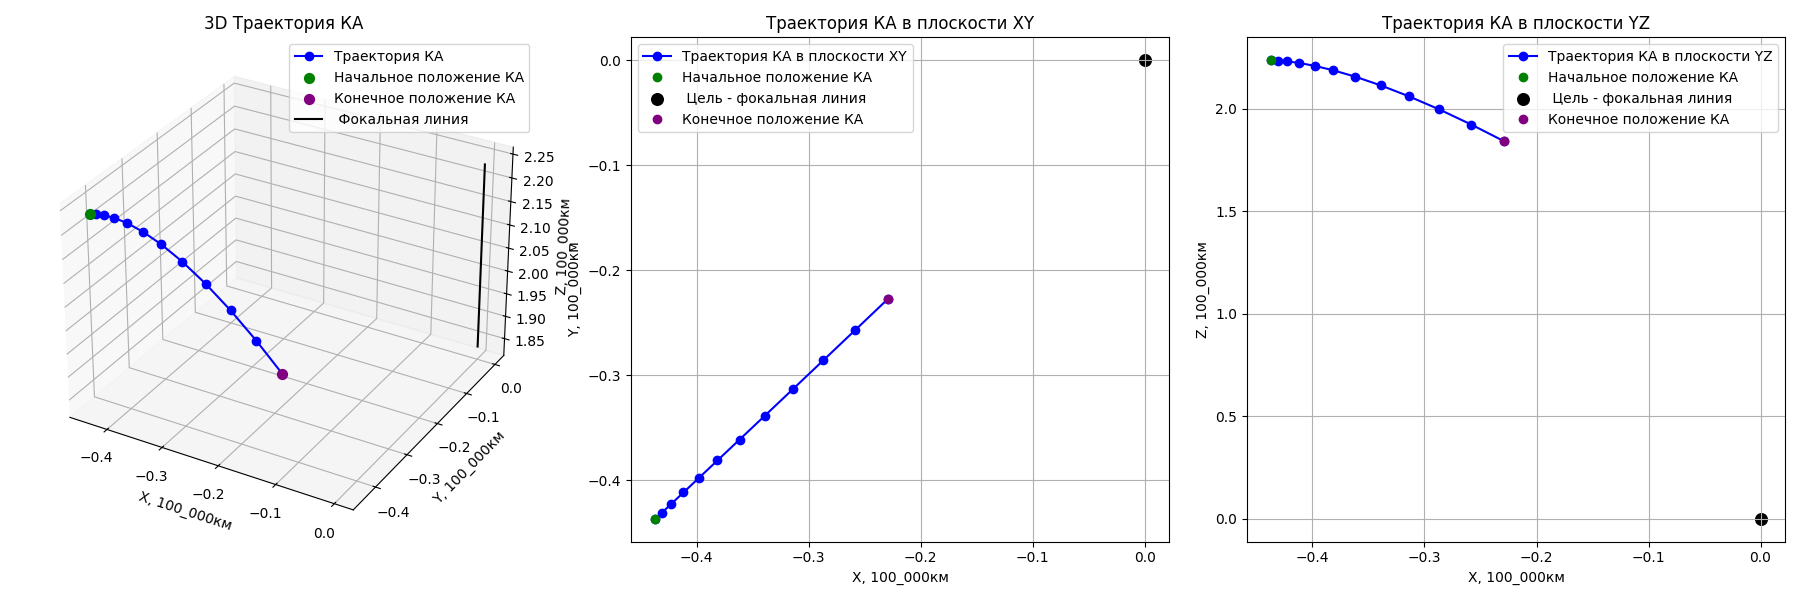

In [102]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Получение окружения и начальных наблюдений
vec_env = model.get_env()
obs = vec_env.reset()

# Инициализация списков для хранения данных
action_array = []
states_array = []
obs_array = []
rewards_array = []
reward_total = 0
reward_total_array = []

for i in range(n_imp):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = vec_env.step(action)
    
    if dones[0]:  # Если эпизод завершен
        obs_array.append(info[0]['terminal_observation'])
        rewards = np.array(info[0]['episode']['r'])
        reward_total_array.append(rewards)
        break

    reward_total += rewards
    obs_array.append(obs[0, :])
    rewards_array.append(rewards)
    reward_total_array.append(reward_total[0])
    action_array.append(action)
    states_array.append(_states)

# Преобразование списков в массивы
action_array = np.array(action_array)
states_array = np.array(states_array)
obs_array = np.array(obs_array)

# Извлекаем координаты из фазового вектора
x_array = obs_array[:, 0] #* 1.496e8  # Координата x, км
y_array = obs_array[:, 1] #* 1.496e8 # Координата y
z_array = obs_array[:, 2] #* 1.496e8 # Координата z

# Извлекаем компоненты скорости
vx_array = obs_array[:, 3]
vy_array = obs_array[:, 4]
vz_array = obs_array[:, 5]

# Создание графиков
fig = plt.figure(figsize=(18, 6))
#3D-график траектории
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(x_array, y_array, z_array, '-o', color='blue', label='Траектория КА')
ax1.scatter(x_array[0], y_array[0], z_array[0], color="green", label="Начальное положение КА", s=50)
ax1.scatter(x_array[-1], y_array[-1], z_array[-1], color="purple", label="Конечное положение КА", s=50)
ax1.plot([0, 0], [0, 0],[np.min(z_array), np.max(z_array)], '-', color='black', label=' Фокальная линия')
ax1.set_title('3D Траектория КА')
ax1.set_xlabel('X, 100_000км')
ax1.set_ylabel('Y, 100_000км')
ax1.set_zlabel('Z, 100_000км')
ax1.legend()


# 2D-график в плоскости (y, z)
ax2 = fig.add_subplot(132)
ax2.plot(x_array, y_array, '-o', color='blue', label='Траектория КА в плоскости XY')
ax2.plot(x_array[0], y_array[0], 'o', color="green", label="Начальное положение КА")
ax2.scatter([0.], [0.], color = 'black', s = 70, label = " Цель - фокальная линия")
ax2.plot(x_array[-1], y_array[-1], 'o', color="purple", label="Конечное положение КА")
ax2.set_title('Траектория КА в плоскости XY')
ax2.set_xlabel('X, 100_000км')
ax2.set_ylabel('Y, 100_000км')
ax2.legend()
ax2.grid()

# 2D-график в плоскости (y, z)
ax3 = fig.add_subplot(133)
ax3.plot(x_array, z_array, '-o', color='blue', label='Траектория КА в плоскости YZ')
ax3.plot(x_array[0], z_array[0], 'o', color="green", label="Начальное положение КА")
ax3.scatter([0.], [0.], color = 'black', s = 70, label = " Цель - фокальная линия")
ax3.plot(x_array[-1], z_array[-1], 'o', color="purple", label="Конечное положение КА")
ax3.set_title('Траектория КА в плоскости YZ')
ax3.set_xlabel('X, 100_000км')
ax3.set_ylabel('Z, 100_000км')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()


In [83]:
save_choice = input("Сохранить обученные веса? ('y' - да, 'n' - нет): ").strip().lower()

if save_choice == 'y':
    save_path = input("Введите путь для сохранения модели: ").strip()  # Ввод пути для сохранения
    model.save(save_path)
    print(f"Модель сохранена в {save_path}.")
else:
    print("Сохранение пропущено.")

#tensorboard --logdir=Dynamics_SGLF

Сохранение пропущено.


In [84]:
num_episodes = 1000  #???

initial_distances = []
final_distances = []
initial_speeds = []
final_speeds = []
u_total = [] # Суммарные затраты характеристической скорости
delta_r_f = []  # Промахи по положению
delta_v_f = []  # Промахи по скорости

for episode in range(num_episodes):
    obs = env_with_dynamics.reset()  # Сброс окружения для нового эпизода
    done = False
    
    # Массивы для хранения данных по каждому эпизоду
    episode_distances = []
    episode_speeds = []
    episode_u = 0  # Суммарные затраты скорости для эпизода
    
    for i in range(n_imp):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action)
        
        if dones[0]:  # Если эпизод завершен
            obs = info[0]['terminal_observation']
            obs = np.array([obs])

        y = obs[0, 1]  
        x = obs[0, 0]  
        vy = obs[0, 4]  
        vx = obs[0, 3] 
        distance_to_focal = np.sqrt(x**2 + y**2)
        speed_to_focal = np.sqrt(vx**2 + vy**2)
        
        delta_v = action * min(1, delta_v_max/numpy.linalg.norm(action))
        episode_u += np.linalg.norm(delta_v)
        episode_distances.append(distance_to_focal)
        episode_speeds.append(speed_to_focal)
        
    
    # Сохраняем начальные и конечные значения для эпизода
    initial_distances.append(episode_distances[0])
    final_distances.append(episode_distances[-1])
    initial_speeds.append(episode_speeds[0])
    final_speeds.append(episode_speeds[-1])
    u_total.append(episode_u)

delta_r_f = (np.array(final_distances)) * KM_SCALE
delta_v_f = np.array(final_speeds) * VEL_SCALE* 1000.
u_total = np.array([u_total]) 
u_total = u_total * VEL_SCALE * 1000.

print('∆rf, км:', statistics(delta_r_f))
print('∆vf, м/с:', (statistics(delta_v_f)))
print('u, м/с:', statistics(u_total))


∆rf, км: (616.9700926883945, 6724.612693851273, 24818.021634820267, 53701.44290083745, 64256.410408282114, 29166.40950950717, 23035.46302468322, 1.2661525178918458)
∆vf, м/с: (617.5223713430369, 899.1155675202107, 1768.743704044347, 2116.208398230743, 2253.517327329932, 1562.2975232524598, 600.4343610623906, 2.601945565687109)
u, м/с: (171.4285034686327, 180.5660722311586, 198.11941171064973, 223.22503244504333, 227.12028212845325, 200.12719160225242, 20.237406909178993, 9.888974041999502)


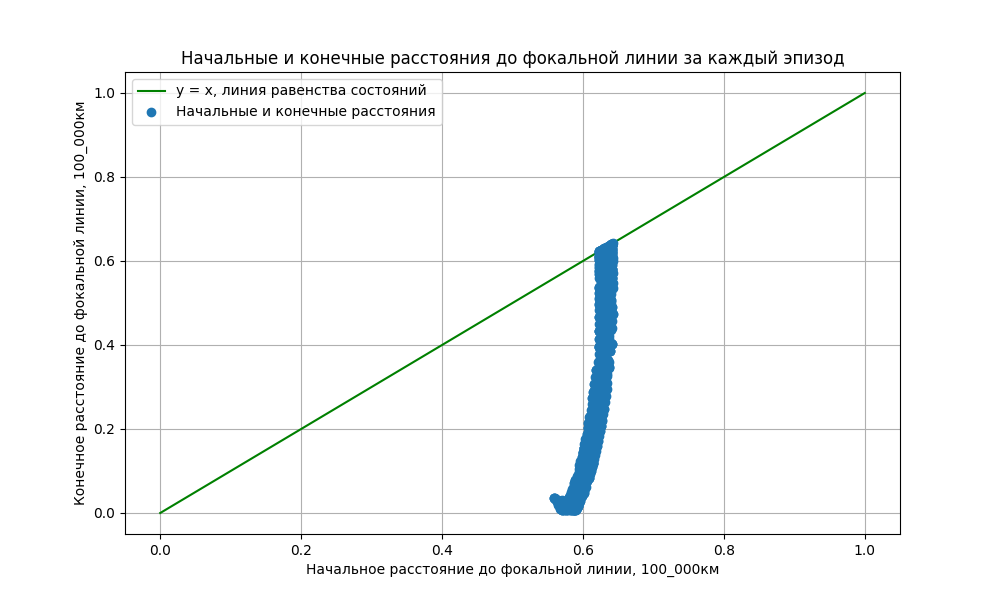

In [87]:
x = np.linspace(0, 1, 100) 
y = x
initial_distances = np.array(initial_distances) 
final_distances = np.array(final_distances) 
plt.figure(figsize=(10, 6))
plt.plot(x, y, label = "y = x, линия равенства состояний", color = 'green')
plt.plot( initial_distances , final_distances , 'o', label="Начальные и конечные расстояния")
plt.xlabel("Начальное расстояние до фокальной линии, 100_000км")
plt.ylabel("Конечное расстояние до фокальной линии, 100_000км")
plt.title("Начальные и конечные расстояния до фокальной линии за каждый эпизод")
plt.legend()
plt.grid(True)
plt.show()


### _______________________________________________________________________________________________________________________

In [86]:
# R0 = 100_000. #/ 1.496e8 #радиус круга, который является областью начальных условий, a.e.
# z = 550.* 1.496e+3 # расстояние от Солнца до начального положения КА на фокальной линии, a.e. 
# z0 = 10. * 9.461e+7#* 63241.1  # расстояние от Солнца до барицентра экзосистемы, а.е.
# DT = 0.05 # Шаг для t_span
# V_0 = 0.2 #25. # скорость аппарата в инерц системе в начальный момент, а.е./год
# n_imp = 16 # число импульсов за эпизод
# delta_v_max = 0.1 #100. * 0.2107e-4 # ограничение скорости импульса агента , а.е./год
# tfinal = 30. / 365.25 # длительность эпизода, год
# #delta_t_imp = tfinal / n_imp  #интервал между импульсами, год
# alfa = 1. #0.1 # весовая константа в выражении для функции вознаграждения, чтобы порядок v и r был одинаковый
# #threshold = 0.1 #10_000. / 1.496e8 # радиус круга-цели на плоскости Oyx, a.e.
# total_timesteps = 1_000 # общее количество шагов во время обучения модели




# 3D-график траектории
# ax1 = fig.add_subplot(131, projection='3d')
# ax1.plot(x_array, y_array, z_array, '-o', color='blue', label='Траектория КА')
# ax1.scatter(x_array[0], y_array[0], z_array[0], color="green", label="Начальное положение КА", s=50)
# ax1.scatter(x_array[-1], y_array[-1], z_array[-1], color="purple", label="Конечное положение КА", s=50)
# ax1.plot([0, 0], [0, 0],[np.min(z_array), np.max(z_array)], '-', color='black', label=' Фокальная линия')
# ax1.set_title('3D Траектория КА')
# ax1.set_xlabel('X, 100_000км')
# ax1.set_ylabel('Y, 100_000км')
# ax1.set_zlabel('Z, 100_000км')
# ax1.legend()
#2D-график в плоскости (y, z)
# ax1 = fig.add_subplot(131)
# ax1.plot(y_array, z_array, '-o', color='blue', label='Траектория КА в плоскости YZ')
# ax1.plot(y_array[0], z_array[0], 'o', color="green", label="Начальное положение КА")
# ax1.scatter([0.], [0.], color = 'black', s = 70, label = " Цель - фокальная линия")
# ax1.plot(y_array[-1], z_array[-1], 'o', color="purple", label="Конечное положение КА")
# ax1.set_title('Траектория КА в плоскости YZ')
# ax1.set_xlabel('Y, 100_000км')
# ax1.set_ylabel('Z, 100_000км')
# ax1.legend()
# ax1.grid()